# Goal

## Time series + EMA

Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

Bonus:

Can you label students who are viewing both the web dev and data science curriculum? Can you label students by the program they are in? Can you label users by student vs. staff? What are Zach, Maggie, David, and Ryan's ids?

In [1]:
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

# Acquire

Our data comes in the form of a text file. First we read in the file and analyze its contents. After a quick glance, we realize there is no header, only a few columns can be easily interrpreted, and clumns are separated by a space. Let's rename those columns that we know.

In [2]:
df = pd.read_csv('anonymized-curriculum-access.txt',sep=" ", header = None)
df.columns = ['date', 'time', 'destination', 'num_1', 'num_2', 'ip_address']
df.head(5)

,date,time,destination,num_1,num_2,ip_address
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [3]:
df.info

<bound method DataFrame.info of               date      time  \
0       2018-01-26  09:55:03   
1       2018-01-26  09:56:02   
2       2018-01-26  09:56:05   
3       2018-01-26  09:56:06   
4       2018-01-26  09:56:24   
5       2018-01-26  09:56:41   
6       2018-01-26  09:56:46   
7       2018-01-26  09:56:48   
8       2018-01-26  09:56:59   
9       2018-01-26  09:58:26   
10      2018-01-26  09:59:22   
11      2018-01-26  10:00:02   
12      2018-01-26  10:00:37   
13      2018-01-26  10:00:39   
14      2018-01-26  10:00:44   
15      2018-01-26  10:00:49   
16      2018-01-26  10:00:57   
17      2018-01-26  10:01:12   
18      2018-01-26  10:02:02   
19      2018-01-26  10:02:21   
20      2018-01-26  10:02:42   
21      2018-01-26  10:05:26   
22      2018-01-26  10:05:36   
23      2018-01-26  10:08:22   
24      2018-01-26  10:08:34   
25      2018-01-26  10:08:45   
26      2018-01-26  10:08:55   
27      2018-01-26  10:09:15   
28      2018-01-26  10:09:24   
29      

In [4]:
df.dtypes

date            object
time            object
destination     object
num_1            int64
num_2          float64
ip_address      object
dtype: object

In [5]:
df.info

<bound method DataFrame.info of               date      time  \
0       2018-01-26  09:55:03   
1       2018-01-26  09:56:02   
2       2018-01-26  09:56:05   
3       2018-01-26  09:56:06   
4       2018-01-26  09:56:24   
5       2018-01-26  09:56:41   
6       2018-01-26  09:56:46   
7       2018-01-26  09:56:48   
8       2018-01-26  09:56:59   
9       2018-01-26  09:58:26   
10      2018-01-26  09:59:22   
11      2018-01-26  10:00:02   
12      2018-01-26  10:00:37   
13      2018-01-26  10:00:39   
14      2018-01-26  10:00:44   
15      2018-01-26  10:00:49   
16      2018-01-26  10:00:57   
17      2018-01-26  10:01:12   
18      2018-01-26  10:02:02   
19      2018-01-26  10:02:21   
20      2018-01-26  10:02:42   
21      2018-01-26  10:05:26   
22      2018-01-26  10:05:36   
23      2018-01-26  10:08:22   
24      2018-01-26  10:08:34   
25      2018-01-26  10:08:45   
26      2018-01-26  10:08:55   
27      2018-01-26  10:09:15   
28      2018-01-26  10:09:24   
29      

Let's run value counts on the different columns 

In [6]:
df.destination.value_counts()

/                                                                            20564
javascript-i                                                                  8140
search/search_index.json                                                      7005
toc                                                                           6679
html-css                                                                      6143
java-iii                                                                      6003
spring                                                                        5761
jquery                                                                        5501
java-ii                                                                       5386
mysql                                                                         5103
java-i                                                                        5039
javascript-ii                                                                 5024
mysq

In [7]:
df.num_1.value_counts()

53     8236
64     8008
11     8004
344    5279
1      4266
314    3233
423    2995
323    2846
354    2821
211    2625
418    2598
127    2563
410    2398
277    2367
347    2318
325    2248
363    2237
433    2217
337    2183
186    2180
274    2136
315    2130
416    2103
368    2063
304    2061
272    2008
197    1993
275    1900
264    1898
269    1894
       ... 
137      10
279      10
84       10
141       9
95        9
388       8
107       8
104       8
401       7
115       6
152       5
399       5
71        5
169       5
82        5
62        4
216       4
85        4
246       4
348       3
177       3
89        3
176       3
81        3
97        2
66        1
461       1
163       1
165       1
212       1
Name: num_1, Length: 543, dtype: int64

In [8]:
df.num_2.value_counts

<bound method IndexOpsMixin.value_counts of 0          8.0
1          8.0
2          8.0
3          8.0
4         22.0
5         22.0
6         22.0
7         22.0
8         22.0
9         22.0
10        22.0
11        22.0
12        22.0
13        22.0
14        22.0
15        22.0
16        22.0
17        22.0
18        22.0
19        22.0
20        22.0
21        22.0
22        22.0
23        21.0
24        21.0
25        21.0
26        21.0
27        22.0
28        22.0
29        22.0
          ... 
399165    52.0
399166    52.0
399167    52.0
399168    52.0
399169    52.0
399170    28.0
399171    28.0
399172    34.0
399173    52.0
399174    52.0
399175    52.0
399176    34.0
399177    34.0
399178    33.0
399179    52.0
399180    33.0
399181    52.0
399182    33.0
399183    33.0
399184    33.0
399185    34.0
399186    28.0
399187    28.0
399188    32.0
399189    32.0
399190    33.0
399191    33.0
399192    34.0
399193    34.0
399194    33.0
Name: num_2, Length: 399195, dtype: float

# Prepare

There are still two unlabled columns that contain integers. I chose to name them num_1 and num_2. After checking the column data types, I see there are data types which should be reassigned. It would also be a good time to combine the date and time columns and set it as the index.

In [9]:
df['datetime'] = df['date'] + " " + df['time']

In [10]:
df['datetime'] = df.datetime.str.replace('-', '/')

In [11]:
df['datetime']= pd.to_datetime(df.datetime.str.replace('-', '/'))

In [12]:
df.dtypes

date                   object
time                   object
destination            object
num_1                   int64
num_2                 float64
ip_address             object
datetime       datetime64[ns]
dtype: object

In [13]:
df.drop(columns=['date', 'time'], inplace = True)

In [14]:
df = df.set_index('datetime')

In [15]:
df.head()

,destination,num_1,num_2,ip_address
datetime,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


# Explore

Here we will begin to explore the data by looking for trends and answering specific questions. The goal here is to get a better idea of the data, and isolate anomalies. If necessary, we will recycle through the prepare phase. 

We have hourly daily data from January 26, 2018 - November 19th, 2019

In [16]:
df.index.max()

Timestamp('2019-11-19 10:07:45')

In [17]:
df.index.min()

Timestamp('2018-01-26 09:55:03')

Text(0.5, 1.0, 'IP Address Count by Day')

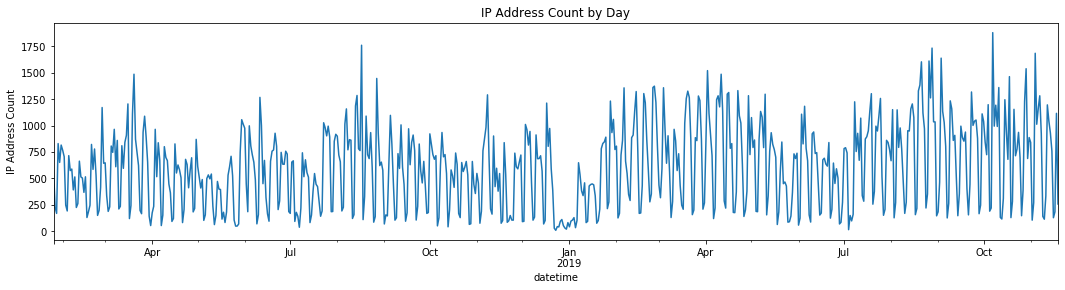

In [176]:
ax = df.resample('D').ip_address.count()
ax.plot(figsize=(18,4))
plt.ylabel('IP Address Count')
plt.title('IP Address Count by Day')

Text(0.5, 1.0, 'IP Address Count by Year, Month, and Day')

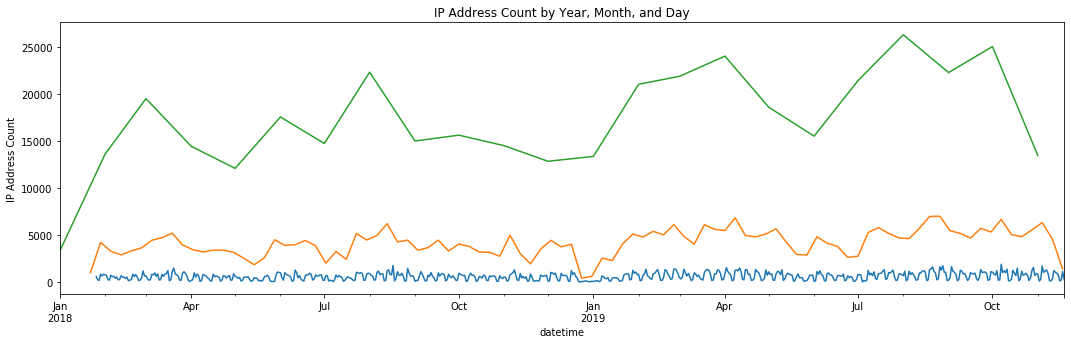

In [175]:
df.resample('D').ip_address.count().plot()
df.resample('W').ip_address.count().plot()
df.resample('M').ip_address.count().plot(figsize=(18,5))
plt.ylabel('IP Address Count')
plt.title('IP Address Count by Year, Month, and Day')

In [20]:
df.groupby('ip_address').count()

,destination,num_1,num_2
ip_address,,,
100.35.67.162,11,11,11
103.208.220.130,1,1,0
103.208.220.131,1,1,0
103.208.220.132,1,1,0
103.208.220.133,1,1,0
103.208.220.137,1,1,0
103.208.220.139,2,2,0
103.208.220.141,1,1,0
103.208.220.143,3,3,0


In [21]:
len(df.groupby('ip_address').count())

2585

- 2,585 unique ip addresses

In [196]:
df.groupby(df.index.weekday_name).ip_address.count()

datetime
Friday       60989
Monday       80702
Saturday     13715
Sunday       19368
Thursday     69771
Tuesday      79558
Wednesday    75092
Name: ip_address, dtype: int64

Substantially less activity on the weekends. Monday, Tuesday, and Wednesday (in that order) have the most traffic.

### Trying to figure out what each unknown column number represents

Assumption: These columns must be used to identify individuals somehow.

In [22]:
df.num_2.nunique()

31

According to Codeup's website, they have had roughly 36 cohorts. Perhaps num_2 is the cohort identifier.

In [23]:
df.num_1.nunique()

543

543/31 = 17.5. Each cohort is roughly 17-20 students. Perhaps this is the student id number

In [89]:
df.groupby('num_1').num_2.value_counts()

num_1  num_2
1      28.0     2649
       8.0      1617
2      22.0     1541
3      22.0     1562
4      22.0      692
5      22.0     1701
6      22.0     1408
7      22.0     1803
8      22.0      483
9      22.0      585
10     21.0      750
11     28.0     5269
       1.0      2735
12     22.0      729
13     22.0       79
14     22.0      596
15     21.0      296
16     21.0      193
17     21.0      175
18     22.0     1455
19     22.0     1518
20     22.0      624
21     16.0      107
22     21.0      199
23     22.0      969
24     21.0       26
25     23.0     1358
       22.0      451
26     18.0      474
27     21.0      482
                ... 
515    33.0      233
516    52.0       62
517    52.0       51
518    52.0       69
519    52.0      104
520    52.0       88
521    52.0      189
522    52.0      133
523    52.0       50
524    52.0      328
525    52.0      105
526    52.0      111
527    52.0       85
528    52.0      120
529    52.0       36
530    52.0      109


In [37]:
df.groupby('num_2').ip_address.count()

num_2
1.0      8877
2.0        93
4.0         4
6.0        72
7.0       461
8.0      1671
9.0         5
11.0      204
12.0      270
13.0     2610
14.0     9069
15.0      691
16.0      740
17.0     3792
18.0     1603
19.0     1142
21.0     7181
22.0    28875
23.0    28056
24.0    35039
25.0    25233
26.0    26760
27.0    20198
28.0    20677
29.0    35969
31.0    22665
32.0    26801
33.0    34433
34.0    15519
51.0    10835
52.0     2896
Name: ip_address, dtype: int64

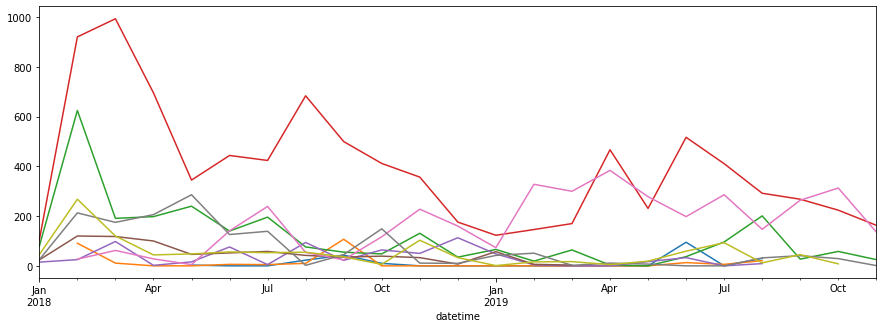

In [86]:
for i in range (11,20):
    cohort_i = df[df.num_2 == i]
    cohort_i.resample('M').ip_address.count().plot(figsize=(15,5))

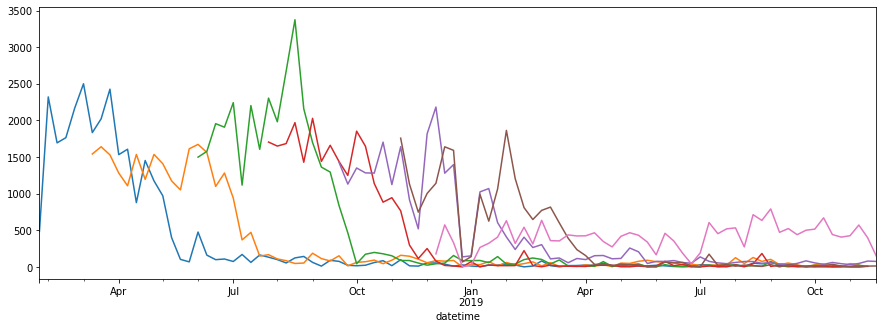

In [84]:
for i in range (22,29):
    cohort_i = df[df.num_2 == i]
    cohort_i.resample('W').ip_address.count().plot(figsize=(15,5))

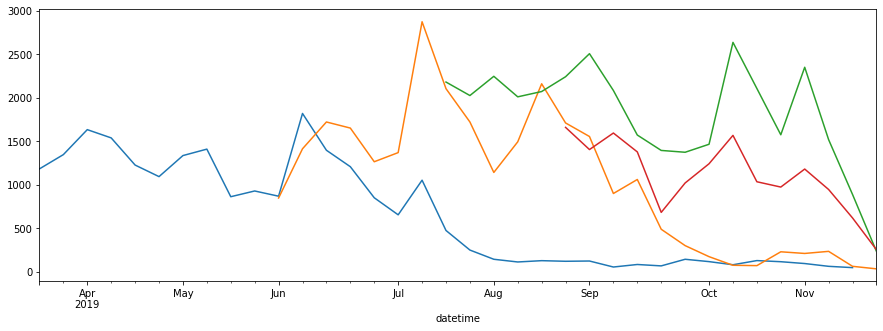

In [83]:
for i in range (31,35):
    cohort_i = df[df.num_2 == i]
    cohort_i.resample('W').ip_address.count().plot(figsize=(15,5))

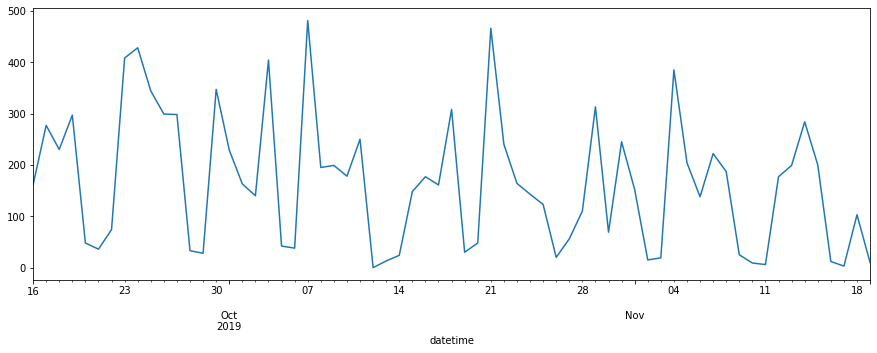

In [93]:
cohort_51 = df[df.num_2 == 51]
cohort_51.resample('D').ip_address.count().plot(figsize=(15,5))

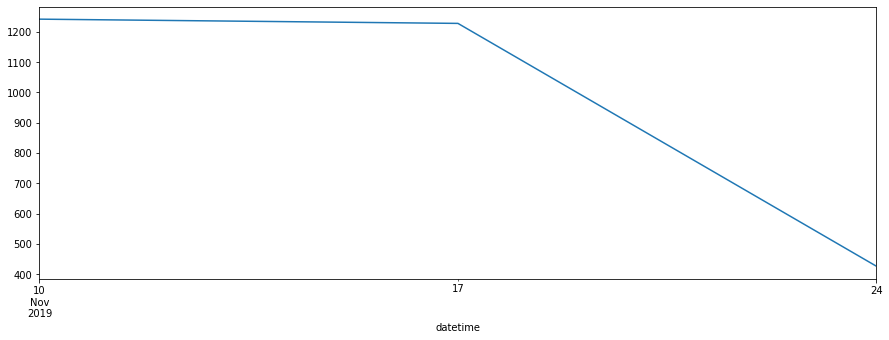

In [90]:
cohort_52 = df[df.num_2 == 52]
cohort_52.resample('W').ip_address.count().plot(figsize=(15,5))

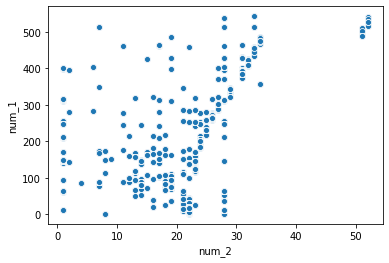

In [104]:
sns.scatterplot(x=df.num_2, y=df.num_1)

### Identifying cohorts

After browsing codeup's website and public instagram account, I was able to create a csv file which shows estimations of cohort begin and end dates. Let's take a look at that data:

In [105]:
cohorts = pd.read_csv('codeup_cohort_info.csv')

In [106]:
cohorts.head(3)

,cohort,start_date,end_date,cohort_grad_count,type
0,Wrangell,7/23/18,11/1/18,17.0,web_dev
1,Xanadu,9/17/18,2/1/19,17.0,web_dev
2,Yosemite,11/6/18,4/3/19,19.0,web_dev


### Investigating the Bayes Cohort

In [153]:
bayes = df[df.num_2 == 34]

In [154]:
bayes

,destination,num_1,num_2,ip_address
datetime,,,,
2019-08-20 09:39:58,/,466,34.0,97.105.19.58
2019-08-20 09:39:59,/,467,34.0,97.105.19.58
2019-08-20 09:39:59,/,468,34.0,97.105.19.58
2019-08-20 09:40:02,/,469,34.0,97.105.19.58
2019-08-20 09:40:08,/,470,34.0,97.105.19.58
2019-08-20 09:40:15,/,471,34.0,97.105.19.58
2019-08-20 09:40:15,/,472,34.0,97.105.19.58
2019-08-20 09:40:17,/,473,34.0,97.105.19.58
2019-08-20 09:40:18,/,474,34.0,97.105.19.58


In [162]:
bayes.groupby('num_1').ip_address.count()

num_1
358     570
466     707
467     361
468     524
469     753
470     413
471     759
472     582
473     815
474     414
475    1316
476    1101
477     266
478     896
479    1343
480     518
481     683
482     949
483     538
484    1047
485     947
487      17
Name: ip_address, dtype: int64

Text(0.5, 1.0, 'IP Address Count by Day')

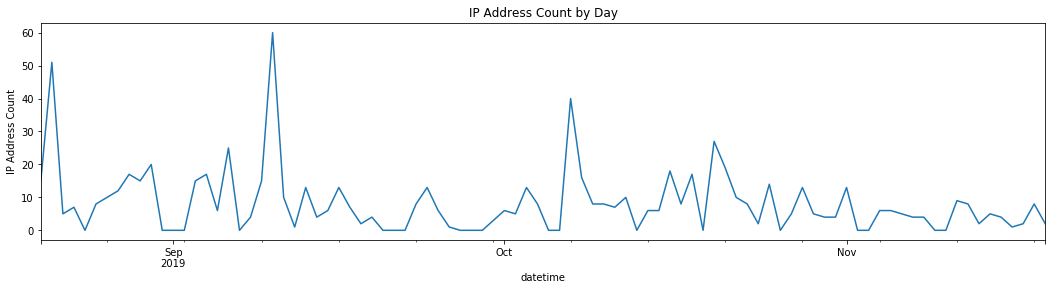

In [174]:
ax = bayes[bayes.num_1==471].resample('D').ip_address.count()
ax.plot(figsize=(18,4))
plt.ylabel('IP Address Count')
plt.title('IP Address Count by Day')

In [173]:
df[df.num_1==471].ip_address.value_counts()

97.105.19.58       622
99.158.246.101      70
216.110.79.11       28
99.158.247.1        19
192.171.117.210     14
75.4.99.66           6
Name: ip_address, dtype: int64

In [178]:
user_471 = df[df.num_1==471]

In [183]:
user_471.resample('D').ip_address.count()

datetime
2019-08-20    15
2019-08-21    51
2019-08-22     5
2019-08-23     7
2019-08-24     0
2019-08-25     8
2019-08-26    10
2019-08-27    12
2019-08-28    17
2019-08-29    15
2019-08-30    20
2019-08-31     0
2019-09-01     0
2019-09-02     0
2019-09-03    15
2019-09-04    17
2019-09-05     6
2019-09-06    25
2019-09-07     0
2019-09-08     4
2019-09-09    15
2019-09-10    60
2019-09-11    10
2019-09-12     1
2019-09-13    13
2019-09-14     4
2019-09-15     6
2019-09-16    13
2019-09-17     7
2019-09-18     2
              ..
2019-10-21    19
2019-10-22    10
2019-10-23     8
2019-10-24     2
2019-10-25    14
2019-10-26     0
2019-10-27     5
2019-10-28    13
2019-10-29     5
2019-10-30     4
2019-10-31     4
2019-11-01    13
2019-11-02     0
2019-11-03     0
2019-11-04     6
2019-11-05     6
2019-11-06     5
2019-11-07     4
2019-11-08     4
2019-11-09     0
2019-11-10     0
2019-11-11     9
2019-11-12     8
2019-11-13     2
2019-11-14     5
2019-11-15     4
2019-11-16     1
2019-

In [188]:
user_471

,destination,num_1,num_2,ip_address
datetime,,,,
2019-08-20 09:40:15,/,471,34.0,97.105.19.58
2019-08-20 09:43:03,1-fundamentals/1.1-intro-to-data-science,471,34.0,97.105.19.58
2019-08-20 09:43:03,1-fundamentals/modern-data-scientist.jpg,471,34.0,97.105.19.58
2019-08-20 09:43:03,1-fundamentals/AI-ML-DL-timeline.jpg,471,34.0,97.105.19.58
2019-08-20 10:54:56,1-fundamentals/1.1-intro-to-data-science,471,34.0,97.105.19.58
2019-08-20 10:54:56,1-fundamentals/modern-data-scientist.jpg,471,34.0,97.105.19.58
2019-08-20 10:54:56,1-fundamentals/AI-ML-DL-timeline.jpg,471,34.0,97.105.19.58
2019-08-20 13:39:18,/,471,34.0,97.105.19.58
2019-08-20 14:01:26,/,471,34.0,97.105.19.58


In [195]:
user_471.groupby(user_471.index.weekday_name).ip_address.count()

datetime
Friday       132
Monday       150
Saturday      15
Sunday        52
Thursday      76
Tuesday      181
Wednesday    153
Name: ip_address, dtype: int64